In [1]:
# Importação dos pacotes necessários
    
import pandas as pd # manipulação de dado em formato de dataframe
import seaborn as sns # biblioteca de visualização de informações estatísticas
import matplotlib.pyplot as plt # biblioteca de visualização de dados
import statsmodels.api as sm # biblioteca de modelagem estatística
import numpy as np # biblioteca para operações matemáticas multidimensionais
from statsmodels.iolib.summary2 import summary_col
from skimage import io
import plotly.graph_objs as go
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_init = pd.read_csv('db_oferta_groupdata.csv', delimiter=';', encoding="utf-8")
df_gera = df_init
df_gera.head()

# converter 'energia(mwh)' para int64
#df_gera['energia(mwh)'] = df_init['energia(mwh)'].str.replace(',', '').astype('int64')

#Características das variáveis do dataset
df_gera.info()

#Estatísticas univariadas
df_gera.describe()

#Checando missing values
missing = df_gera.isna().any()
print("Columns with missing values:")
print(missing)

,data,energia(mwmed),temp
0,01/01/2016,17205,25.6
1,01/02/2016,17435,26.1
2,01/03/2016,14569,21.2
3,01/04/2016,14897,17.3
4,01/05/2016,15772,12.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   data            90 non-null     object 
 1   energia(mwmed)  90 non-null     int64  
 2   temp            90 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


,energia(mwmed),temp
count,90.000000,90.000000
mean,15917.811111,18.836000
std,1391.267532,5.112697
min,12612.000000,10.600000
25%,14859.750000,14.150000
50%,15771.500000,18.150000
75%,17042.500000,23.425000
max,19651.000000,30.300000


Columns with missing values:
data              False
energia(mwmed)    False
temp              False
dtype: bool


In [3]:
# Inverter ordem das colunas para ter data mais atualizada primeiro

df_gera['data'] = pd.to_datetime(df_gera['data'], format='%d/%m/%Y')

df_gera.head()
df_gera.describe()


,data,energia(mwmed),temp
0,2016-01-01,17205,25.6
1,2016-02-01,17435,26.1
2,2016-03-01,14569,21.2
3,2016-04-01,14897,17.3
4,2016-05-01,15772,12.6


,data,energia(mwmed),temp
count,90,90.000000,90.000000
mean,2019-09-16 04:00:00,15917.811111,18.836000
min,2016-01-01 00:00:00,12612.000000,10.600000
25%,2017-11-08 12:00:00,14859.750000,14.150000
50%,2019-09-16 00:00:00,15771.500000,18.150000
75%,2021-07-24 06:00:00,17042.500000,23.425000
max,2023-06-01 00:00:00,19651.000000,30.300000
std,NaN,1391.267532,5.112697


In [4]:

#removendo valores nulos
df_gera.rename(columns = {'energia(mwmed)':'energia'},inplace=True)

# Removing null values in the 'energia' column
df_gera = df_gera[df_gera['energia'].notnull()]

df_gera.describe()

,data,energia,temp
count,90,90.000000,90.000000
mean,2019-09-16 04:00:00,15917.811111,18.836000
min,2016-01-01 00:00:00,12612.000000,10.600000
25%,2017-11-08 12:00:00,14859.750000,14.150000
50%,2019-09-16 00:00:00,15771.500000,18.150000
75%,2021-07-24 06:00:00,17042.500000,23.425000
max,2023-06-01 00:00:00,19651.000000,30.300000
std,NaN,1391.267532,5.112697


In [5]:
# Calculando z-scores para temp e energia
z_scores_temp = (df_gera['temp'] - df_gera['temp'].mean()) / df_gera['temp'].std()
z_scores_energia = (df_gera['energia'] - df_gera['energia'].mean()) / df_gera['energia'].std()

# Definir a thereshold para detecção de anomalias
threshold = 2

df_gera = df_gera[(np.abs(z_scores_temp) < threshold)]

df_gera.describe()

,data,energia,temp
count,89,89.000000,89.000000
mean,2019-09-01 23:43:49.213483264,15875.865169,18.707191
min,2016-01-01 00:00:00,12612.000000,10.600000
25%,2017-11-01 00:00:00,14850.000000,14.100000
50%,2019-09-01 00:00:00,15771.000000,18.100000
75%,2021-07-01 00:00:00,17035.000000,23.200000
max,2023-06-01 00:00:00,19138.000000,26.900000
std,NaN,1340.697598,4.992643


,energia,temp
energia,1.000000,0.146681
temp,0.146681,1.000000


<Figure size 1080x720 with 0 Axes>

<AxesSubplot:>

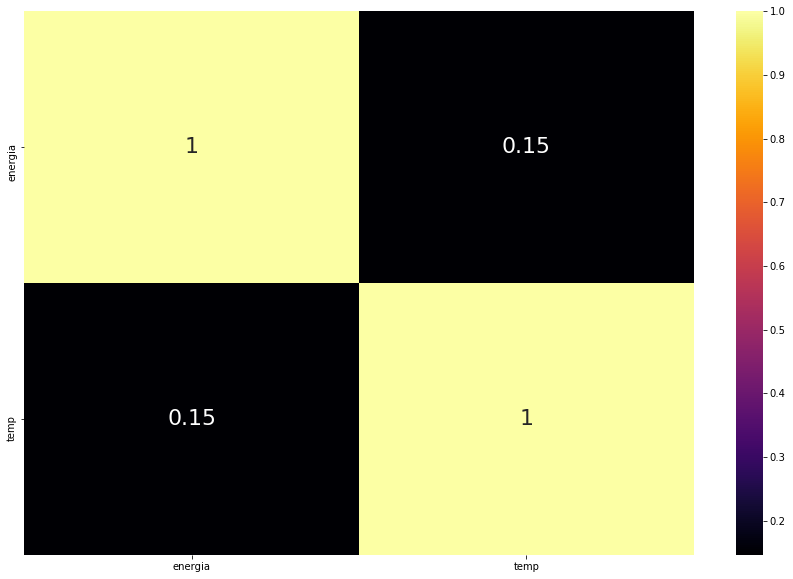

In [6]:
# Matriz de correlações
#dropando coluna date
df_corr = df_gera.drop(columns='data')
# Calculate the correlation matrix
corr = df_corr.corr()
corr

plt.figure(figsize=(15,10))
sns.heatmap(df_corr.corr(), annot=True, cmap = plt.cm.inferno,
            annot_kws={'size':22})
plt.show()

In [7]:
# Estimando um modelo múltiplo com as variáveis do dataset 'paises'

#Estimando a regressão múltipla
modelo_OLS = sm.OLS.from_formula("energia ~ temp", df_gera).fit()

#Parâmetros do modelo
modelo_OLS.summary()

#Parâmetros do modelo com intervalos de confiança
#Nível de significância de 5% / Nível de confiança de 95%
modelo_OLS.conf_int(alpha=0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                energia   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.913
Date:                Thu, 21 Sep 2023   Prob (F-statistic):              0.170
Time:                        22:39:17   Log-Likelihood:                -765.70
No. Observations:                  89   AIC:                             1535.
Df Residuals:                      87   BIC:                             1540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.514e+04    551.194     27.466      0.000     1.4e+04    1.62e+04
temp          39.3889     28.479      1.383      0.170     -17.215      95.993
==============================================================================
Omnibus:                        1.788   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.653
Skew:                           0.224   Prob(JB):                        0.437
Kurtosis:                       2.506   Cond. No.                         75.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,0,1
Intercept,14043.451046,16234.567751
temp,-17.215274,95.993084


In [8]:
# Transformação de Box-Cox

#Para o cálculo do lambda de Box-Cox
from scipy.stats import boxcox

#xt é uma variável que traz os valores transformados (Y*)
#'lmbda' é o lambda de Box-Cox
xt, lmbda = boxcox(df_gera['energia'])

print("Primeiros valores: ",xt[:5])
print("Lambda: ",lmbda)

Primeiros valores:  [3.97850407 3.98001488 3.95920051 3.9618264  3.96849905]
Lambda:  -0.2227124630968691


In [9]:
df_gera['bc_energia'] = xt
df_gera

,data,energia,temp,bc_energia
0,2016-01-01,17205,25.60,3.978504
1,2016-02-01,17435,26.10,3.980015
2,2016-03-01,14569,21.20,3.959201
3,2016-04-01,14897,17.30,3.961826
4,2016-05-01,15772,12.60,3.968499
...,...,...,...,...
84,2023-01-01,19138,26.90,3.990493
85,2023-02-01,18571,25.80,3.987135
87,2023-04-01,14599,18.43,3.959444
88,2023-05-01,15121,13.84,3.963579


In [10]:
# Estimando um novo modelo múltiplo com variável dependente
#transformada por Box-Cox

modelo_bc = sm.OLS.from_formula('bc_energia ~  temp', df_gera).fit()

# Parâmetros do modelo
modelo_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bc_energia   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.785
Date:                Thu, 21 Sep 2023   Prob (F-statistic):              0.185
Time:                        22:39:17   Log-Likelihood:                 286.99
No. Observations:                  89   AIC:                            -570.0
Df Residuals:                      87   BIC:                            -565.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9636      0.004    985.392      0.000       3.956       3.972
temp           0.0003      0.000      1.336      0.185      -0.000       0.001
==============================================================================
Omnibus:                        0.830   Durbin-Watson:                   1.000
Prob(Omnibus):                  0.660   Jarque-Bera (JB):                0.840
Skew:                           0.002   Prob(JB):                        0.657
Kurtosis:                       2.524   Cond. No.                         75.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### temp não estatísticamente significante como uma variável explicativa. Então vamos excluí-los

In [11]:
# Preparar dados para modelo OLS quadratico
xdata = df_gera['temp']
ydata = df_gera['energia']


# Create a DataFrame for the statsmodels OLS
data = {'ydata': ydata, 'xdata': xdata}
df = pd.DataFrame(data)

# Fit the OLS model using statsmodels
modelo_qd = sm.OLS.from_formula('ydata ~ xdata + np.power(xdata, 2)', data=df).fit()
# Parâmetros do modelo
modelo_qd.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ydata   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     150.3
Date:                Thu, 21 Sep 2023   Prob (F-statistic):           8.61e-29
Time:                        22:39:17   Log-Likelihood:                -699.79
No. Observations:                  89   AIC:                             1406.
Df Residuals:                      86   BIC:                             1413.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.439e+04   1156.539     29.731      0.000    3.21e+04    3.67e+04
xdata              -2171.6597    130.066    -16.697      0.000   -2430.222   -1913.098
np.power(xdata, 2)    59.0382      3.454     17.094      0.000      52.172      65.904
==============================================================================
Omnibus:                        0.540   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.536
Skew:                           0.179   Prob(JB):                        0.765
Kurtosis:                       2.871   Cond. No.                     7.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 720x720 with 0 Axes>

<AxesSubplot:xlabel='temp', ylabel='energia'>

<AxesSubplot:xlabel='temp', ylabel='energia'>

<AxesSubplot:xlabel='temp', ylabel='energia'>

Text(0.5, 1.0, 'Dados dispersos - modelo quadrático')

Text(0.5, 0, 'Temperatura (Cº)')

Text(0, 0.5, 'Carga (mWe)')

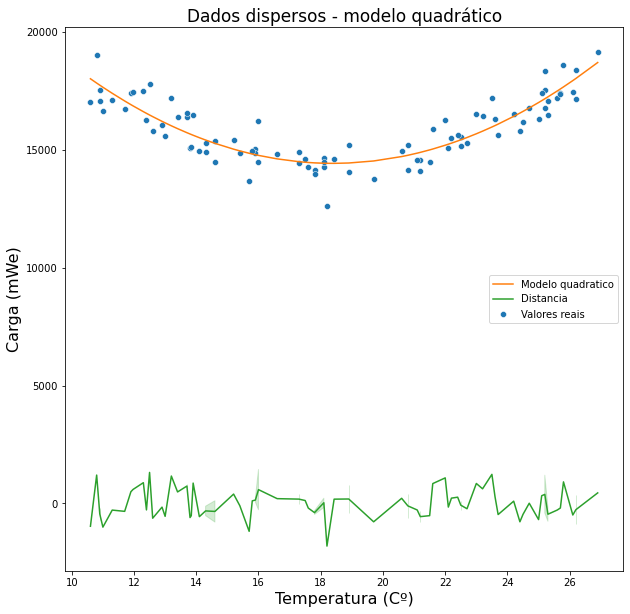

In [12]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="temp", y="energia", data=df_gera, color='#1f77b4', label='Valores reais')
sns.lineplot(x=df_gera['temp'].to_numpy(), y=modelo_qd.fittedvalues.to_numpy(), color='#ff7f0e', label='Modelo quadratico')
sns.lineplot(x=df_gera['temp'].to_numpy(), y=df_gera['energia'].to_numpy() - modelo_qd.fittedvalues.to_numpy(), color='#2ca02c', label='Distancia')
plt.title('Dados dispersos - modelo quadrático', fontsize=17)
plt.xlabel('Temperatura (Cº)', fontsize=16)
plt.ylabel('Carga (mWe)', fontsize=16)
plt.legend()
plt.show()

In [13]:
df_gera['yhat_qd'] = (modelo_qd.fittedvalues)

#Visualizando os dois fitted values no dataset
#modelos 'modelo_step_empresas e modelo_step_empresas_bc
df_gera[['data','energia','temp', 'yhat_qd']]

,data,energia,temp,yhat_qd
0,2016-01-01,17205,25.60,17482.283121
1,2016-02-01,17435,26.10,17922.591453
2,2016-03-01,14569,21.20,14880.433976
3,2016-04-01,14897,17.30,14485.316924
4,2016-05-01,15772,12.60,16395.475367
...,...,...,...,...
84,2023-01-01,19138,26.90,18688.484541
85,2023-02-01,18571,25.80,17654.864160
87,2023-04-01,14599,18.43,14415.004002
88,2023-05-01,15121,13.84,15638.221061


In [14]:
# Verificando a normalidade dos resíduos do 'modelo_OLS' e 'modelo_bc2'
from scipy.stats import shapiro
# Teste de Shapiro-Francia
sf_test_ols = shapiro(modelo_OLS.resid.to_numpy())
sf_test_qd = shapiro(modelo_qd.resid.to_numpy())
sf_test_bc = shapiro(modelo_bc.resid.to_numpy())

print("p-value ols:", sf_test_ols.pvalue)
print("p-value bc:", sf_test_bc.pvalue)
print("p-value qd:", sf_test_qd.pvalue)

p-value ols: 0.33318454027175903
p-value bc: 0.5055853128433228
p-value qd: 0.29500487446784973


<Figure size 720x432 with 0 Axes>

(array([6.92213361e-05, 0.00000000e+00, 0.00000000e+00, 6.92213361e-05,
        6.92213361e-05, 1.38442672e-04, 4.84549353e-04, 5.53770689e-04,
        4.15328017e-04, 9.69098705e-04, 4.84549353e-04, 5.53770689e-04,
        5.53770689e-04, 4.84549353e-04, 2.76885344e-04, 1.38442672e-04,
        4.15328017e-04, 6.92213361e-05, 2.76885344e-04, 1.38442672e-04]),
 array([-1805.09456895, -1642.77532333, -1480.45607772, -1318.1368321 ,
        -1155.81758649,  -993.49834088,  -831.17909526,  -668.85984965,
         -506.54060403,  -344.22135842,  -181.9021128 ,   -19.58286719,
          142.73637843,   305.05562404,   467.37486966,   629.69411527,
          792.01336088,   954.3326065 ,  1116.65185211,  1278.97109773,
         1441.29034334]),
 <BarContainer object of 20 artists>)

Text(0.5, 0, 'Resíduos')

Text(0, 0.5, 'Densidade')

Text(0.5, 1.0, 'Resíduos modelo quadrático')

Text(0.05, 0.7, 'Shapiro-Wilk p-value: 0.30')

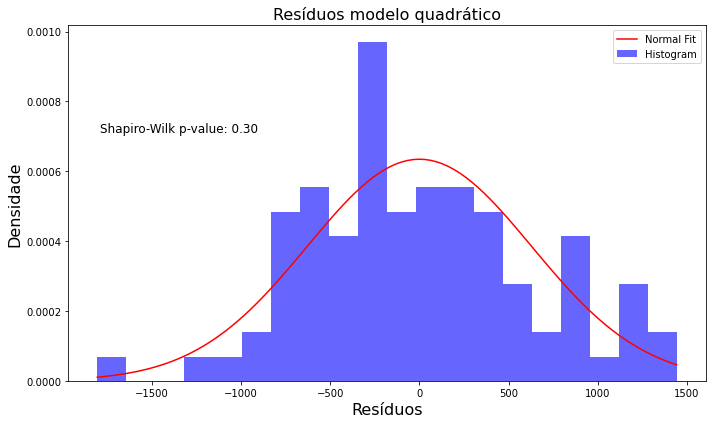

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, shapiro

# Resíduos dos modelos
resid_array_ols = modelo_OLS.resid.to_numpy()
resid_array_qd = modelo_qd.resid.to_numpy()
resid_array_bc = modelo_bc.resid.to_numpy()

# Create a single figure
plt.figure(figsize=(10, 6))

# Plot OLS Quadrático
plt.hist(resid_array_qd, bins=20, density=True, color='blue', alpha=0.6, label='Histogram')
x_range_qd = np.linspace(min(resid_array_qd), max(resid_array_qd), 100)
mu_qd, std_qd = norm.fit(resid_array_qd)
pdf_qd = norm.pdf(x_range_qd, mu_qd, std_qd)
plt.plot(x_range_qd, pdf_qd, label="Normal Fit", color='red')
plt.xlabel('Resíduos', fontsize=16)
plt.ylabel('Densidade', fontsize=16)
plt.title('Resíduos modelo quadrático', fontsize=16)

# Shapiro-Wilk test for normality
sf_test_qd = shapiro(resid_array_qd)
plt.annotate(f"Shapiro-Wilk p-value: {sf_test_qd.pvalue:.2f}",
             xy=(0.05, 0.7), xycoords='axes fraction', fontsize=12)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [16]:
# Resumo dos  três modelos obtidos
#(linear e com Box-Cox)

summary_col([modelo_OLS, modelo_bc, modelo_qd],
            model_names=["OLS","STEPWISE BOX-COX","QUADRATICO"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs))
        })

,OLS,STEPWISE BOX-COX,QUADRATICO
Intercept,15139.0094***,3.9636***,34385.4784***
,(551.1943),(0.0040),(1156.5392)
R-squared,0.0215,0.0201,0.7775
R-squared Adj.,0.0103,0.0088,0.7723
"np.power(xdata, 2)",,,59.0382***
,,,(3.4537)
temp,39.3889,0.0003,
,(28.4785),(0.0002),
xdata,,,-2171.6597***
,,,(130.0657)
